### Abdullah Almaharmeh 


## Problem Statement

Job agency received thaousands of resumes per month, and they don't have the ability to analyze them by employes cuz this may take alot of time and effort.

so they ask a data scientest to help them analyzing the resumes and answer few question about the dataset


Importing required library

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from textblob import TextBlob
%matplotlib inline

In [2]:
# read the csv file
df = pd.read_csv("resume updated.csv")

#### looking into the data 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2492 entries, 0 to 2491
Columns: 164 entries, ID to Unnamed: 163
dtypes: object(164)
memory usage: 3.1+ MB


In [4]:
df.columns
# we can see that we have alot off columns that we wrongly read 
# we must drop it now 

Index(['ID', 'Resume_str', 'Category', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       ...
       'Unnamed: 154', 'Unnamed: 155', 'Unnamed: 156', 'Unnamed: 157',
       'Unnamed: 158', 'Unnamed: 159', 'Unnamed: 160', 'Unnamed: 161',
       'Unnamed: 162', 'Unnamed: 163'],
      dtype='object', length=164)

In [5]:
df= df[['ID','Resume_str','Category']]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2492 entries, 0 to 2491
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          2492 non-null   object
 1   Resume_str  2492 non-null   object
 2   Category    2465 non-null   object
dtypes: object(3)
memory usage: 58.5+ KB


as we see there isn't null values in the data and we have four columns, let's talk about them.


#### ID 
Unique identifier and file name for the respective pdf.

#### Resume_str 
contains the resume text only in string format.
#### Resume_html 
Contains the resume data in html format as present while web scrapping.
#### Category 
Category of the job the resume was used to apply
  

### let's check the categories in this dataset

In [7]:
df.Category.value_counts()

INFORMATION-TECHNOLOGY                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    119
BUSINESS-DEVELOPMENT                                                                                                                                                                                                                                                                                                      

In [8]:
# we want to drop this columns where the category isn't looking good
# the process we'll follow that any category appears less than 5 we will drop it 

thresholed = 5
cat_counts = df['Category'].value_counts()

df = df[df['Category'].isin(cat_counts[cat_counts >= thresholed].index)]

In [9]:
df.Category.value_counts()

INFORMATION-TECHNOLOGY    119
BUSINESS-DEVELOPMENT      119
AVIATION                  117
CHEF                      117
FITNESS                   117
ACCOUNTANT                116
ENGINEERING               116
FINANCE                   116
BANKING                   115
ADVOCATE                  115
SALES                     115
CONSULTANT                115
HEALTHCARE                113
PUBLIC-RELATIONS          110
HR                        109
CONSTRUCTION              108
DESIGNER                  106
ARTS                      103
TEACHER                   102
APPAREL                    96
DIGITAL-MEDIA              95
AGRICULTURE                63
AUTOMOBILE                 35
BPO                        21
Name: Category, dtype: int64

In [10]:
# discover null values and what we will do with them 
df.isna().sum()

ID            0
Resume_str    0
Category      0
dtype: int64

In [11]:
# checking for duplicates 
df.duplicated().sum()

0

now we can go on !!!

Our main task is to Create a descriptive csv file from the plain-text samples with the following columns:
* POSITION_TITLE: Job title. 
* QUALIFICATIONS: The qualifications that each applicant had for the job 
* EDUCATION _TYPE: type of education that the applicant had (master, bachelor, diploma….) 
* SCHOOL_TYPE: The type of school the applicant study in (university, college, high school) 
* EDUCATION_MAJOR: The education major you study in this school. 
* EXPERIENCE_LENGTH: The number of experience years needed to apply for this job. 
* AWORDS: If the applicant had an award or not.
* COMMUNITY SERVICE: If the applicant had a community service work or not. 
* VOLUNTEERING: If the applicant had any volunteering or not.
* DRIVERS_LICENSE_AVAILABILITY: Is driver license available or not for this applicant. 
* SKILLS_COUNT: number of skills that the applicant had.
* SKILLS: the skill that applicant had. 
* Languages: the number of languages for each applicant.

In [12]:
#lets make the datafram we want to fill
# we add new column "Languages_count"
des_csv = pd.DataFrame(columns=['POSITION_TITLE','QUALIFICATIONS','EDUCATION_TYPE','SCHOOL_TYPE',
                                 'EDUCATION_MAJOR','EXPERINCE_LENGHT','AWORDS','COMMUNITY_SERVICE',
                                 'VOLUNTEERING','DRIVERS_LICENSE_AVAILABILITY','SKILLS_COUNT'
                                ,'SKILLS','LANGUAGES','LANGUAGES_COUNT'])

In [13]:
# take look on data how it's look like 
s= df.Resume_str.iloc[2]
s

'         HR DIRECTOR       Summary      Over 20 years experience in recruiting,   15 plus years in Human Resources Executive Management,   5 years of HRIS development and maintenance  4 years working in a Healthcare Enviroment        Skills          Recruiting  FMLA/EEO/FLSA\xa0  HRIS Development      Benefit Administration  Policy Development  Web Page Development\xa0            Accomplishments      Kansas Health Institute -Health Outcomes for the State of Kansas -1999 \nMemberships and Accolades: Project Management Institute Member, SHRM, Chamber of Commerce, 1999 Friends University President\'s Honor Roll, 1997 Friends University Dean\'s Honor Roll, Student Liaison for Friends University Topeka (member of Mother-To-Mother, member of the Topeka \nAdvertising Federation, several production pieces created nominated for ADDY Awards, received recognition for outstanding customer service assistance by the State of Kansas Travel and Tourism Department., ASHHRA, KAHHR, ACM.  Additional Inf

In [14]:
# define function to fill POSITION_TITLE column 
def PositionTitle(resume , descriptive,columnName):
    for i in range(resume.shape[0]) :
        s = df.Resume_str.iloc[i]
        #splitting the text by white spaces
        lines = s.split() 
        processed_lines = []

        for line in lines:
            #if the whol word is upper case or space add it to the list 
            if (line.isupper()) | ( line ==' '):
                processed_lines.append(line)
            else :
                break
        # joining words on processed _line list into on line text 
        processed_text = ' '.join(processed_lines)  # Join the processed lines back into a text
        descriptive.at[i,columnName] = processed_text

#### Education and school type 

In [15]:
"""
remove_extra_spaces function 
take a text as input then 
* replace all occurrences of one or more consecutive whitespace characters with a single space.
* his line replaces occurrences of a dot followed by a space ('. ') with just a dot ('.')
then return the text
"""
def remove_extra_spaces(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.replace('. ', '.')
    return text

In [16]:
"""
process_text function take this inputs :
1) text --> represent the text we process.
2) keyword --> certin word we want to find and split after it appears.
3) stop_words -->list contains word that we want to stop splitting when any of them appears appears.

in general this function return the text between the keyword and any of the stop words. 
The poirity is to find the key word as a first word on the sentence, if we can't find it on this condition 
we search about any appearance of it in the text, if we can't find it too then we return the all text.
"""

def process_text(text, keyword, stop_words=[]):
    
    # clean the text from white space
    text = re.sub(r'\s+', ' ', text)
    text = text.replace('. ', '.')
    # split text by the dot or new lines 
    sentences = re.split(r'[\.\n]', text)
    # create flag to tell us if we find the word or not 
    index = -1
    for sentence in sentences:
        # check on every senttence if it start with the key word 
        if sentence.strip().startswith(keyword):
            # Keep the text after the sentence with the keyword (delte all before the keyword)
            text = text[text.index(sentence):]
            # find the index of the keywrod 
            index = text.index(keyword)
            break
    # if we can't find the key word on the first of sentence we search on all text about it
    if index == -1:
        index = text.find(keyword)
        
    if index != -1:
        # Keep the text after the keyword
        text = text[index+len(keyword):]
        
        
        # search about stopwrods using regex pattern (non capture group)
        pattern = r'[\.\n\s]\s*(?:' + '|'.join(stop_words) + r')\b'
        stop_index = re.search(pattern, text)

        if stop_index:
            # Remove stop words and everything after the first occurrence
            text = text[:stop_index.start()]
    
    return text


In [17]:
"""
SchoolType funciton takes three inputs :- 
resume :- the dataframe that contains resumes we want to extract information from.
descriptive :- the dataframe we want to fill information on .
columnName :- the name of the column on our descriptive data .


This function fill the schooltype column 
"""


def SchoolType(resume , descriptive,columnName):
    # define keywords and stop_words that we will use on processf unction 
    keyword = 'Education'
    stop_words = ['Languages','Skills','Summary','Qualification','Experience'
                  ,'Highlights','Conclusion','Additional',"Accomplishments",
                 'Work History','Researches']
    # iterate on all resumes 
    for i in range(resume.shape[0]) :
        s = resume.Resume_str.iloc[i]
        processed_text = process_text(s, keyword, stop_words)
        # search about famous school type on that text 
        pattern = r"(university|college|high school|institute)"
        school_type = re.search(pattern,processed_text.lower(),flags=re.IGNORECASE)
        if school_type : 
            school_type = school_type.group(0)
        
        # fill the the column with the value 
        descriptive.at[i,columnName] = school_type

In [18]:
"""
SchoolType funciton takes three inputs :- 
resume :- the dataframe that contains resumes we want to extract information from 
descriptive :- the dataframe we want to fill information on 
columnName :- the name of the column on our descriptive data 


This function fill the Education_Type colmun 
"""

def EducationType(resume,discriptive,columnName):
    # define the keyword and stopwords for process function
    keyword = 'Education'
    stop_words = ['Languages','Skills','Summary','Qualification','Experience'
              ,'Highlights','Conclusion','Additional',"Accomplishments",
             'Work History','Researches']
    # iterate over all resumes 
    for i in range(resume.shape[0]) :
        s = resume.Resume_str.iloc[i]
        processed_text = process_text(s, keyword, stop_words)
        # split by white space 
        words = processed_text.split()
        for j in range (len(words)):
            # if any word contains of uppercase then just let it as it is, to catch abbreviations
            if words[j].isupper():
                continue
            else:
                words[j] = words[j].lower()
        text = ' '.join(words)
    # i will define patterns for each education type (famous one) 
        patterns = [
        (r"(ph\.D?|doctor|doctorate|P.?h.?D.?|D.?Ph.?|D.?L.?i.?t.?|D.?Sc.?|D.?Eng.?|D.?Min.?|Th.?D.?|LL.?D.?|J.?D.?|Ed.?D.?|Psy.?D.?|M.?D.?-Ph.?D.?|Au.?D.?|D.?C.?M.?|D.?O.?-Ph.?D.?|D.?N.?P.?|D.?C.?N.?P.?|D.?S.?N.?|D.?P.?T.?)", "Doctor"),
        (r"(master|M\.?A\.?|M\.?S\.?|M\.?B\.?A\.?|M\.?Ed\.?|M\.?F\.?A\.?|M\.?S\.?W\.?|M\.?P\.?H\.?|M\.?P\.?A\.?|M\.?S\.?N\.?|M\.?L\.?I\.?S\.?)", "Master"),
        (r"(bachelor|B\.?A\.?|B\.?S\.?|B\.?B\.?A\.?|B\.?E\.?D\.?|B\.?F\.?A\.?|B\.?S\.?W\.?|B\.?P\.?H\.?|B\.?P\.?A\.?|B\.?S\.?N\.?|B\.?L\.?I\.?S\.?|B\.?H\.?R\.?M\.?|B\.?C\.?O\.?M\.?|B\.?T\.?E\.?C\.?H\.?|B\.?D\.?E\.?S\.?|B\.?A\.?M\.?S\.?|B\.?E\.?D\.?U\.?|B\.?C\.?S\.?|B\.?L\.?A\.?W\.?|B\.?F\.?I\.?N\.?|B\.?C\.?H\.?E\.?M\.?|B\.?B\.?M\.?S\.?|B\.?N\.?A\.?T\.?|B\.?C\.?S\.?E\.?|B\.?M\.?T\.?E\.?C\.?H\.?|B\.?C\.?A\.?R\.?E\.?|B\.?C\.?O\.?R\.?P\.?E\.?D\.?|B\.?C\.?A\.?T\.?H\.?|B\.?F\.?M\.?A\.?|B\.?C\.?O\.?M\.?P\.?|B\.?I\.?N\.?T\.?L\.?B\.?U\.?S\.?|B\.?C\.?I\.?V\.?I\.?L\.?E\.?|B\.?D\.?I\.?V\.?M\.?E\.?D\.?I\.?A\.?|B\.?E\.?L\.?E\.?C\.?T\.?R\.?O\.?N\.?I\.?C\.?S\.?|B\.?S\.?E\.?C\.?O\.?N\.?|B\.?H\.?U\.?M\.?A\.?N\.?I\.?T\.?I\.?E\.?S\.?|B\.?L\.?I\.?B\.?E\.?R\.?A\.?L\.?A\.?R\.?T\.?S\.?|B\.?I\.?N\.?T\.?E\.?R\.?N\.?A\.?T\.?I\.?O\.?N\.?A\.?L\.?S\.?T\.?U\.?D\.?I\.?E\.?S\.?|B\.?E\.?L\.?E\.?A\.?R\.?N\.?I\.?N\.?G\.?S\.?|B\.?S\.?B\.?A\.?S\.?|B\.?A\.?S\.?E\.?D\.?)", "Bachelor"),
        (r"(associate|A.?A.?|A.?S.?|A.?A.?S.?|A.?B.?|A.?A.?T.?|A.?P.?S.?|A.?T.?|A.?C.?|A.?E.?|A.?I.?S.?|A.?N.?|A.?P.?N.?|A.?P.?M.?|A.?C.?S.?|A.?H.?|A.?S.?N.?|A.?S.?T.?|A.?V.?|A.?C.?A.?|A.?S.?S.?)", "Associate"),
        (r"(diploma)", "Diploma"),
        (r"(high school+)", "High School")
    ]
        for pattern, education_type in patterns:
            match = re.search(pattern, text)
            if match:
                des_csv.at[i,'EDUCATION_TYPE']=education_type
                break
        else:
            des_csv.at[i,'EDUCATION_TYPE']=None

### Volunteering column



In [19]:
"""
Volunteering_column function takes three inputs. 
resume :- the dataframe that contains resumes we want to extract information from. 
descriptive :- the dataframe we want to fill information on .
columnName :- the name of the column on our descriptive data.
"""


def Volunteering_column(resume,descriptive,columnName):
    #iterate on all resumes
    for i in range(resume.shape[0]):
        # remove extraspaces and change it to lower case 
        s = remove_extra_spaces(resume.Resume_str.iloc[i].lower())
        # if we find any of these words fill the column with ture, else fill it with false 
        find = re.search(r"(volunteer|community.service|non-?profit|charity|philanthropy|club|hub)",s)

        if find:
            des_csv.at[i,columnName] = 1
        else:
            des_csv.at[i,columnName] = 0


### AWORDS column

In [20]:
"""
Awords_column function takes three inputs. 
resume :- the dataframe that contains resumes we want to extract information from. 
descriptive :- the dataframe we want to fill information on .
columnName :- the name of the column on our descriptive data.

This function fill (colmunName) with 0 or 1 represents if the applicants have awords or not
"""

def Awords_column(resume,descriptive,columnName):
    for i in range(resume.shape[0]):
        # remove extra spaces and make text on lower form 
        s = remove_extra_spaces(resume.Resume_str.iloc[i].lower())
        # search on this words 
        find = re.search(r"(award|honors?|prize|recognitions?|commendation)", s)

        if find:
            des_csv.at[i,columnName] = 1
        else:
            des_csv.at[i,columnName] = 0


### Community Scerivce column

In [21]:
"""
CommunityService_column function takes three inputs. 
resume :- the dataframe that contains resumes we want to extract information from. 
descriptive :- the dataframe we want to fill information on .
columnName :- the name of the column on our descriptive data.

This function fill (colmunName) with 0 or 1 represents if the applicants do any communityservice or not
"""


def CommunityService_column(resume,descriptive,columnName):
    for i in range(resume.shape[0]):
        s = remove_extra_spaces(resume.Resume_str.iloc[i].lower())

        find = re.search(r"(community.?service|social.?work|public.?service|civic.?engagement|volunteerism|charity.?work|non-?profit.?involvement|outreach.?programs|humanitarian.?efforts|service.?projects|community.?involvement|social.?activism|philanthropic.?work|giving.?back|club)",s)

        
        if find:
            descriptive.at[i,columnName] = 1
        else:
            descriptive.at[i,columnName] = 0


### Drive license avalability  column 

In [22]:
"""
DriveLicenseAvailability_column function takes three inputs. 
resume :- the dataframe that contains resumes we want to extract information from. 
descriptive :- the dataframe we want to fill information on .
columnName :- the name of the column on our descriptive data.

This function fill (colmunName) with 0 or 1 represents if the applicant have drive license or not
"""


def DriveLicenseAvailability_column(resume,descriptive,columnName):
    for i in range(resume.shape[0]):

        s = resume.Resume_str.iloc[i].lower()

        find = re.search(r"(\bdriver\b|\bdriv(er's|ing) license\b)",s)

        if find:
            descriptive.at[i,columnName] = 1 
        else :
            descriptive.at[i,columnName] = 0


### Language Column 

In [23]:

# define list with most common languages needed in the market, and other common languages ingeneral
languages = [
    "english", "chinese", "spanish", "arabic", "hindi", "bengali", "portuguese",
    "russian", "japanese", "punjabi", "german", "javanese", "wu", "malay", "telugu",
    "vietnamese", "korean", "french", "marathi", "tamil", "urdu", "turkish", "italian",
    "yue", "thai", "gujarati", "jinyu", "southern min", "persian", "polish", "pashto",
    "kannada", "xinyan", "sundanese", "maithili", "hausa", "odia", "burmese", "hakka",
    "ukrainian", "bhojpuri", "tagalog", "yoruba", "maithili", "swahili", "uzbek",
    "sindhi", "amharic", "fula", "romanian", "azerbaijani", "dutch", "yoruba", "nepali",
    "yunan", "punjabi", "farsi", "javanese", "laotian", "xiang", "malayalam", "xiang",
    "saraiki", "khmer", "kurmanji", "konkani", "tigrinya", "madurese", "serbo-croatian",
    "sindhi", "sylheti", "assamese", "somali", "marwari", "magahi", "haryanvi", "hungarian",
    "chhattisgarhi", "greek", "chewa", "czech", "kazakh", "deccan", "minangkabau", "dhuwa",
    "kinyarwanda", "sanaani", "saraiki", "min", "haitian creole", "shona", "zulu",
    "catalan", "cantonese", "uighur", "bi", "tajik", "belarusian", "bakhtiari", "sunda",
    "haitian", "hokkien", "tigrinya", "mosotho", "kanuri", "latvian", "southern min",
    "maithili", "sylheti", "venezuelan sign language"
]

In [24]:

"""
LANGUAGES_column function takes five inputs 
resume :- the dataframe that contains resumes we want to extract information from. 
descriptive :- the dataframe we want to fill information on .
col1 :- the name of the (languages column) on the descriptive data.
col2 :- name of the (languages column) on the descriptive data.
languages :- list of popular languages you need to search about 

This function fills two column languges that the applicant speeks, and fill the other column with the
number of languges. 

"""
def LANGUAGES_column(resume, descriptive, col, col2, languages):
    # define stop words and keyword for preprocessing function  
    keyword = 'Languages'
    stop_words = ['Skills','Education','Summary','Qualification','Experience','Highlights','Conclusion','Additional']
    for i in range(resume.shape[0]):
        
        s = process_text(resume.Resume_str.iloc[i], keyword, stop_words)
        # define pattren to find languages from the list 
        pattern = r"\b(" + "|".join(languages) + r")\b"
        # find all matches 
        found_languages = re.findall(pattern, s.lower())
        # we create set to avoid recurrence
        unique_languages = list(set(found_languages))
        number_of_languages = len(unique_languages)
        # if we find languages then fill colmuns with it 
        if found_languages:
            if 'english' not in unique_languages:
                unique_languages.append('english')
                number_of_languages += 1
            descriptive.at[i, col] = ','.join(unique_languages)
            descriptive.at[i, col2] = number_of_languages
        # else make language english 
        else:
            descriptive.at[i, col] = 'english'
            descriptive.at[i, col2] = 1


## Education major 


In [25]:
#create keyword and stopwords to use in this column 
keyword = 'Education'
stop_words = ['Languages','Skills','Summary','Qualification','Experience'
              ,'Highlights','Conclusion','Additional',"Accomplishments",
             'Work History','Researches']
def EducationMajor_column(resume,descriptive,colName):
    for i in range(resume.shape[0]):
        if descriptive.EDUCATION_TYPE[i] == "high school":
            descriptive.at[i,colName] = 'high school'
        else : 
            s = process_text(resume.Resume_str.iloc[i],keyword,stop_words)
            s = s.lower()
            # the education major appear on the first 150 word nearly 
            s = s[:150].split(': ')
            # if we find splitting then take the first value after splitting 
            if len(s) > 1 :
                s = s[1]
            else :
                # search after 'of'
                s = s[0].split('of')
                if len(s) > 1:
                    s = s[1]
                else: 
                    s= 'none'
            pattern = '([a-z]+(?:\s[a-z]+)?)'
            match = re.search(pattern,s)
            if match :
                if match.group(0)=='none':
                    des_csv.at[i,colName] = None
                else:
                    des_csv.at[i,colName] = match.group(0)
            else :
                des_csv.at[i,colName] = None


### Skills and skills count columns 

In [26]:
keyword = 'Skills'
stop_words = ['Languages','Education','Summary','Qualification','Experience'
              ,'Highlights','Conclusion','Additional',"Accomplishments",
             'Work History','Researches']

In [27]:
"""
This function create list with most common skills to claen our results 


"""
def common_skills (df):
    famous = []
    for i in range(df.shape[0]):
        # reach the Skills section on resume
        s = process_text(df.Resume_str.iloc[i], keyword, stop_words)
        s = s.lower()
        # it seems in most cases skills separted by comma 
        s = s.split(',')

        famous.extend(s)

    famous = (pd.Series(famous)).value_counts()
    # chose skills that appears more than 3 times 
    famous = famous[famous.values >3]
    famous = famous.drop(' c')
    return famous


In [28]:
famous = common_skills(df)

In [29]:
"""
Skills_columns function takes five inputs :- 
resume :- the dataframe that contains resumes we want to extract information from. 
descriptive :- the dataframe we want to fill information on .
skill_col :- the name of the (skill column) on the descriptive data.
count_col :- name of the (skills number column) on the descriptive data.
skills_famous :- list that we create from the prevous function, we saperate the operation to make you feel free to 
use your own skills if you want .

This function looks on skills section on the resume and try to catch all skills from it.

"""
def Skills_columns(resume,descriptive,skill_col,count_col,skills_famous):
    for i in range(df.shape[0]):
        s = process_text(df.Resume_str.iloc[i], keyword, stop_words)
        s = s.lower()
        # split skills section by comma 
        s = s.split(',')
        
        # search on each skill in s if it appears on common skill 
        for j in range(len(s)):
            skill_found = False
            for skill in famous.index:
                if str(skill) in s[j]: 
                    s[j] = str(skill)
                    skill_found = True
                    break

            if not skill_found:
                s[j] = " "
        s = [item for item in s if item.strip()]
        descriptive.at[i,skill_col] = ",".join(s)  
        descriptive.at[i,count_col] = len(s)

### EXPERINCE_LENGHT column

In [30]:
# create function to calculate the lenght between dates in list of experince dates that we take from every user 

from datetime import datetime
# we will give this function list of dates that an applicant workd at 
def find_experience_years(date_list):
    current_year = datetime.now().year
    total_years = 0
    #create month dictionary to catch all forms that month may appears with. 
    month_dict = {
        'jan': 'january', 'feb': 'february', 'mar': 'march', 'apr': 'april', 'may': 'may', 'jun': 'june',
        'jul': 'july', 'aug': 'august', 'sep': 'september', 'oct': 'october', 'nov': 'november', 'dec': 'december'
    }

    for date_range in date_list:
        # define all forms that the date may appear with
        pattern = r"(\b(?:january|jan|february|feb|march|mar|april|apr|may|june|jun|july|jul|august|aug|september|sep|october|oct|november|nov|december|dec)\b)?\s?(\d{4}|\d{2}/\d{4})\b\s?(?:-|to)\s?(\b(?:january|jan|february|feb|march|mar|april|apr|may|june|jun|july|jul|august|aug|september|sep|october|oct|november|nov|december|dec)\b)?\s?(\d{4}|\d{2}/\d{4}|\bcurrent\b)"
        
        
        matches = re.findall(pattern, date_range)
        # start end perioud 
        for start_month, start_year, end_month, end_year in matches:
            if '/' in start_year:
                start_month, start_year = start_year.split('/')
            start_month = month_dict.get(start_month.lower(), 'january')
            start_month = datetime.strptime(start_month, "%B").month
            start_date = datetime(int(start_year), start_month, 1)
            
            if end_year == "current":
                end_date = datetime.now()
            else:
                if '/' in end_year:
                    end_month, end_year = end_year.split('/')
                end_month = month_dict.get(end_month.lower(), 'january')
                end_month = datetime.strptime(end_month, "%B").month
                end_date = datetime(int(end_year), end_month, 1)
            
            duration = end_date - start_date
            
            # Calculate the duration in years
            years = duration.days / 365.25  # Account for leap years
            
            # Consider any experience less than a year as one year
            if duration.days < 365.25:
                years = 1
            
            total_years += years

    return int(total_years)

In [31]:
# create function to fill the data frame with experince lenght 

def Experince_column (resume,descriptive,columnName):
    pattern = r'(\b[a-z]+\b \d{4}\b to?-? \b[a-z]+\b \d{4}\b|\b[a-z]+\b \d{4}\b to?-?\bcurrent\b|\d{2}/\d{4} [a-z-]+ \d{2}/\d{4}|\d{2}/\d{4} to? ?-?current)'
    for i in range(df.shape[0]):
        s = df.Resume_str.iloc[i]
        text = ' '.join(s.split())
        text = text.replace('. ', '.')
        text = text.lower()
        matches = re.findall(pattern, text)
        if matches:
            exp = find_experience_years(matches)
            descriptive.at[i,columnName] = exp

### QUALIFICATIONS Column

In [32]:
keyword = ''
stop_words = ['Languages','Education','Experience'
              ,'Conclusion','Additional',"Accomplishments",
             'Work History','Researches']

In [33]:
def Qualification_column(resume,descriptive,columnName):
    pattern = r'(Qualification|Highlights|Summary)'
    for i in range(resume.shape[0]):
        s = resume.Resume_str.iloc[i]
        text = ' '.join(s.split())
        text = text.replace('. ', '.')

        find = re.search(pattern,text)
        if find:
            text = process_text(s,keyword=find.group(0),stop_words=stop_words)
            sentences = re.split(r'[\.\n]', text.lower())
            if len(sentences)>3:
                sentence = ",".join(sentences)
                sentence = sentence.split(',')
                descriptive.at[i,columnName] = ",".join(sentence[:5])
            else:
                descriptive.at[i,columnName] = ",".join(sentences)
        

In [34]:
#Creating the 
PositionTitle(df,des_csv,'POSITION_TITLE')
SchoolType(df,des_csv,'SCHOOL_TYPE')
EducationType(df,des_csv,'EDUCATION_TYPE')
Volunteering_column(df,des_csv,'VOLUNTEERING')
Awords_column(df,des_csv,'AWORDS')
CommunityService_column(df,des_csv,"COMMUNITY_SERVICE")
DriveLicenseAvailability_column(df,des_csv,'DRIVERS_LICENSE_AVAILABILITY')
LANGUAGES_column(df,des_csv,"LANGUAGES","LANGUAGES_COUNT",languages)
EducationMajor_column(df,des_csv,'EDUCATION_MAJOR')
Skills_columns(df,des_csv,"SKILLS","SKILLS_COUNT",famous)
Experince_column(df,des_csv,'EXPERINCE_LENGHT')
Qualification_column(df,des_csv,'QUALIFICATIONS')
Qualification_column(df,des_csv,'QUALIFICATIONS')

In [35]:
numerical_columns = ['EXPERINCE_LENGHT', 'SKILLS_COUNT', 'LANGUAGES_COUNT']

for column in numerical_columns:
    des_csv[column] = des_csv[column].astype(float)

In [36]:
des_csv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2458 entries, 0 to 2457
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   POSITION_TITLE                2458 non-null   object 
 1   QUALIFICATIONS                2196 non-null   object 
 2   EDUCATION_TYPE                2334 non-null   object 
 3   SCHOOL_TYPE                   2315 non-null   object 
 4   EDUCATION_MAJOR               1672 non-null   object 
 5   EXPERINCE_LENGHT              2352 non-null   float64
 6   AWORDS                        2458 non-null   object 
 7   COMMUNITY_SERVICE             2458 non-null   object 
 8   VOLUNTEERING                  2458 non-null   object 
 9   DRIVERS_LICENSE_AVAILABILITY  2458 non-null   object 
 10  SKILLS_COUNT                  2458 non-null   float64
 11  SKILLS                        2458 non-null   object 
 12  LANGUAGES                     2458 non-null   object 
 13  LAN

In [37]:
des_csv.head()

,POSITION_TITLE,QUALIFICATIONS,EDUCATION_TYPE,SCHOOL_TYPE,EDUCATION_MAJOR,EXPERINCE_LENGHT,AWORDS,COMMUNITY_SERVICE,VOLUNTEERING,DRIVERS_LICENSE_AVAILABILITY,SKILLS_COUNT,SKILLS,LANGUAGES,LANGUAGES_COUNT
0,HR ADMINISTRATOR/MARKETING ASSOCIATE HR ADMINI...,dedicated customer service manager with 15+ y...,Diploma,college,experience in,13.0,1,0,0,0,2.0,"customer service, customer service",english,1.0
1,"HR SPECIALIST, US HR OPERATIONS",versatile media professional with background ...,Master,university,essional with,14.0,0,0,0,0,4.0,"hr, hr, marketing, human resources",english,1.0
2,HR DIRECTOR,"over 20 years experience in recruiting, 15 pl...",Master,university,hris development,21.0,1,0,0,0,3.0,"director, human resources, hr",english,1.0
3,HR SPECIALIST,"dedicated, driven, and dynamic with over 20 y...",None,None,customer service,6.0,0,0,0,0,6.0,"hr, clients, excel, access, outlook, excel",english,1.0
4,HR MANAGER,hr skills hr department startup three new org...,Bachelor,university,None,11.0,0,0,1,0,6.0,"policies, office, excel, powerpoint, access, ...",english,1.0


### <span style="color:orange">Task 2

Assume you are a DA in a company and you are about to prepare a report to the LA governate about there jobs, by answering some questions and give insight about the data provided.

### Note: This section will be a QA cells.

### <span style="color:brown">Q1:

Review the number of applicants for each position

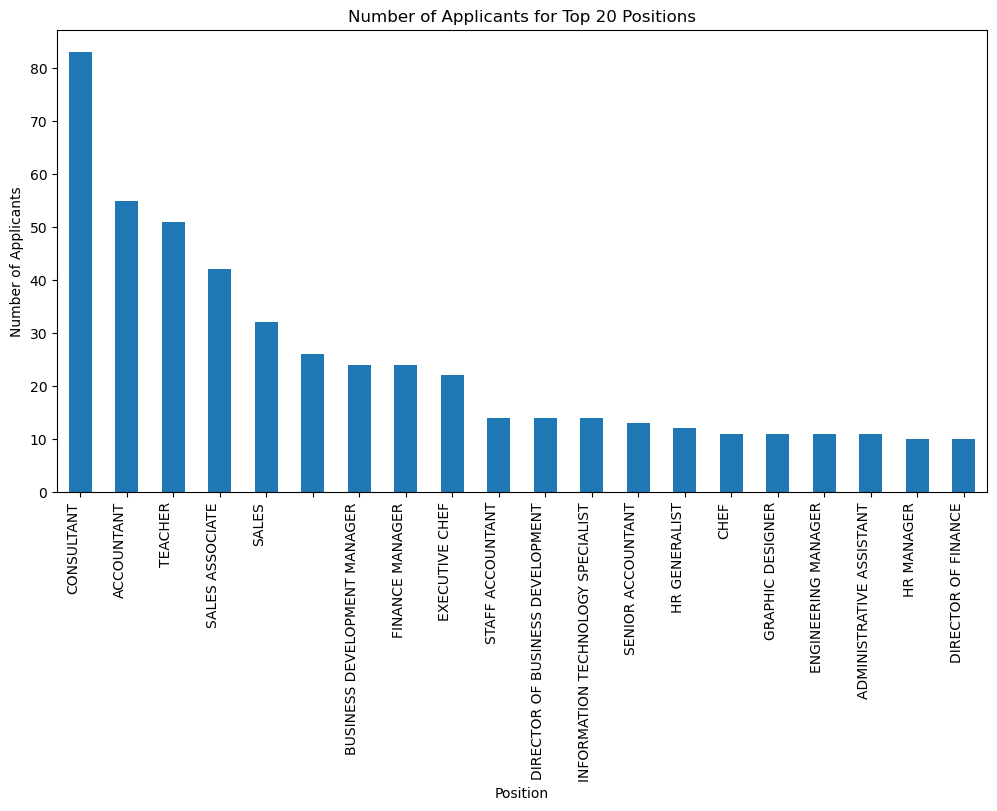

In [38]:
position_counts = des_csv.POSITION_TITLE.value_counts()

top_20_positions = position_counts.head(20)

plt.figure(figsize=(12, 6))
top_20_positions.plot(kind='bar')
plt.title('Number of Applicants for Top 20 Positions')
plt.xlabel('Position')
plt.ylabel('Number of Applicants')
plt.xticks(rotation=90,ha='right')
plt.show()

### <span style="color:brown">Q2:

A concerned parents contacts you to tell them if there is a specific school type that would guaranteed for their child a good future if you can tell, and which is it ?

the approach i will follow that i will compear each school type with mean of experience len and mena of skills count 

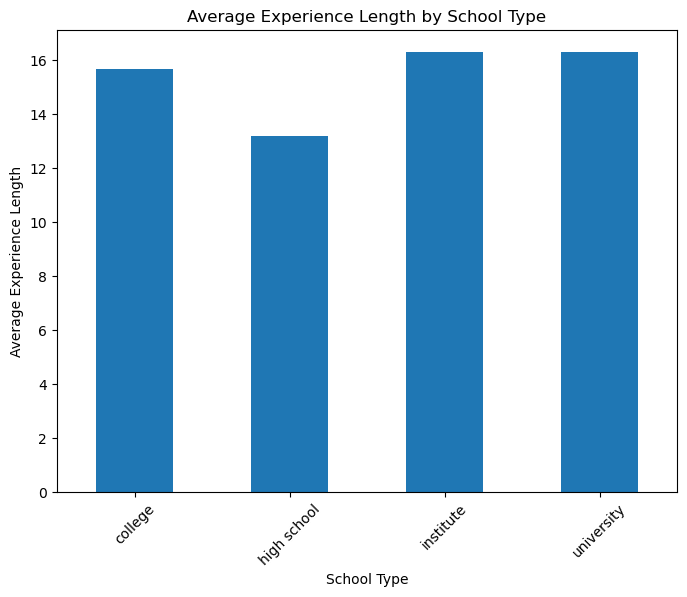

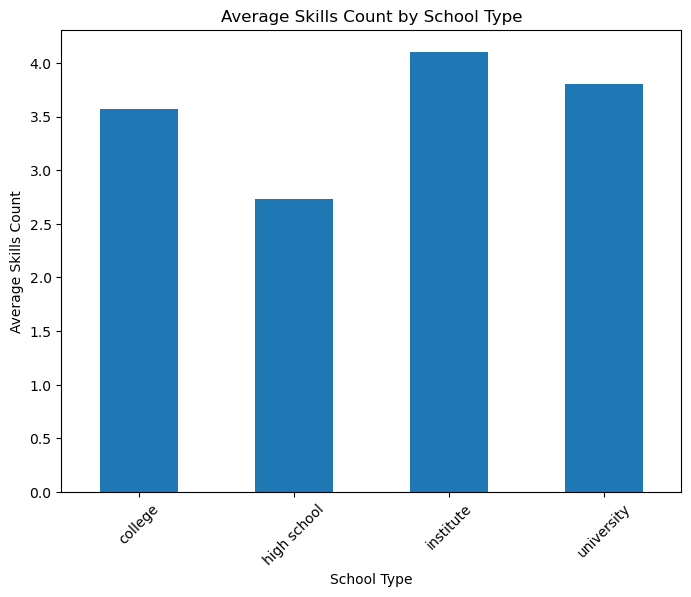

In [39]:
data = des_csv[['SCHOOL_TYPE', 'EXPERINCE_LENGHT', 'SKILLS_COUNT']]

# Group data by school type
grouped_data = data.groupby('SCHOOL_TYPE').mean()


plt.figure(figsize=(8, 6))
grouped_data['EXPERINCE_LENGHT'].plot(kind='bar')
plt.title('Average Experience Length by School Type')
plt.xlabel('School Type')
plt.ylabel('Average Experience Length')
plt.xticks(rotation=45)
plt.show()


plt.figure(figsize=(8, 6))
grouped_data['SKILLS_COUNT'].plot(kind='bar')
plt.title('Average Skills Count by School Type')
plt.xlabel('School Type')
plt.ylabel('Average Skills Count')
plt.xticks(rotation=45)
plt.show()


so i will tell them, if they want their son has more skills then let him go to institute, but if they need a job with salary(which need expericnce with skills) then go to university 

### <span style="color:brown">Q3:

what is the most common skills among all applications?

I had created 'famous'list which contain the most common language so i'll resue it 

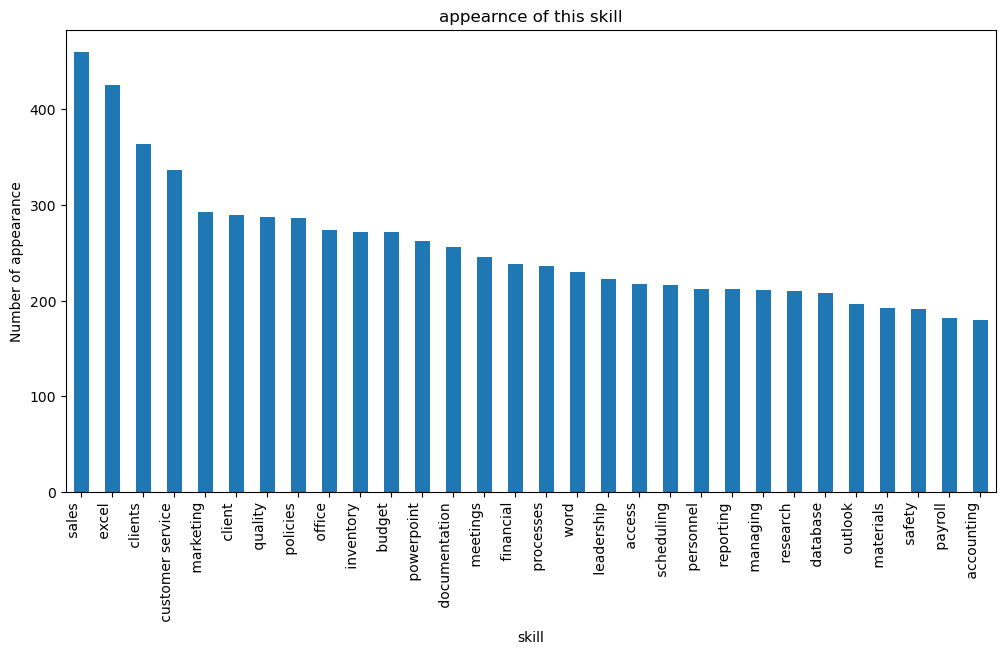

In [40]:

common_skills = famous.head(30)

plt.figure(figsize=(12, 6))
common_skills.plot(kind='bar')
plt.title('appearnce of this skill')
plt.xlabel('skill')
plt.ylabel('Number of appearance')
plt.xticks(rotation=90,ha='right')
plt.show()

# <span style="color:brown">Q4:

Based on the data that you have, could you tell the most active and community helpful applicants are for what position?

here we will group the data by position and find the sum of volunteering and community scervies and then create bar plot with the results 

### <span style="color:brown">Q5:

could you nominate the best job application for each position?

here i think about the craiterica that we consider about to find best job application,mybe we want higer skill_count or more experince 

### <span style="color:brown">Q6:

Do you think learning another language could effect the application, support your opinion.

my opinion is yes it effect , and i can support that by show you how skills increase when we have more than one language

## <span style="color:brown">Q7:

Give a full statistical description for all numrical data columns including all insights and needed figures to visualize them.

In [41]:
des_csv.describe()

,EXPERINCE_LENGHT,SKILLS_COUNT,LANGUAGES_COUNT
count,2352.000000,2458.000000,2458.000000
mean,15.852466,3.617575,1.287632
std,10.924430,4.084602,0.639764
min,1.000000,0.000000,1.000000
25%,8.000000,1.000000,1.000000
50%,14.000000,2.000000,1.000000
75%,22.000000,5.000000,1.000000
max,100.000000,50.000000,7.000000
